In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
p= "/content/drive/MyDrive/"

In [41]:
# ==============================================================================
#                 PASO 1: INSTALACIÓN DE LIBRERÍAS Y DESCARGA DE DATOS
# ==============================================================================
# Usamos -q para una instalación silenciosa.
!pip install -q pandas numpy scikit-learn xgboost matplotlib seaborn uvicorn fastapi pydantic joblib pytest imbalanced-learn


In [42]:
df = pd.read_csv("/content/drive/MyDrive/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv", sep=',', on_bad_lines='skip')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [43]:
# ==============================================================================
#                 PASO 2: CÓDIGO DEL PIPELINE COMPLETO
# ==============================================================================

# ------------------------------------------------------------------------------
# IMPORTS NECESARIOS
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import os
import joblib
from typing import Optional

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb

# Evaluación
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# ------------------------------------------------------------------------------
# MÓDULO utils/data_loader.py (unificado)
# ------------------------------------------------------------------------------
def load_raw_data(file_path: str) -> Optional[pd.DataFrame]:
    """Carga los datos crudos desde un archivo CSV."""
    try:
        df = pd.read_csv(file_path, sep=',', on_bad_lines='skip')
        print("Datos cargados exitosamente.")
        return df
    except FileNotFoundError:
        print(f"Error: El archivo no fue encontrado en {file_path}")
        return None


In [45]:
# ------------------------------------------------------------------------------
# MÓDULO features/feature_engineering.py (unificado)
# ------------------------------------------------------------------------------
def preprocess_and_split(df: pd.DataFrame, target: str):
    """
    Procesa el dataframe y prepara los datos para el pipeline de imblearn.

    Returns:
        X (pd.DataFrame): DataFrame con las características procesadas.
        y (pd.Series): Serie con la variable objetivo.
        preprocessor (ColumnTransformer): El objeto preprocesador ajustado.
    """
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df.dropna(inplace=True)

    df[target] = df[target].apply(lambda x: 1 if x == 'Yes' else 0)

    categorical_features = df.select_dtypes(include=['object']).columns
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(target)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    X = df.drop(columns=[target], axis=1)
    y = df[target]

    return X, y, preprocessor


In [46]:
# ------------------------------------------------------------------------------
# MÓDULO models/model_factory.py (unificado)
# ------------------------------------------------------------------------------
class ModelFactory:
    """Clase que crea instancias de modelos y las prepara para la optimización."""

    @staticmethod
    def create_model_base(model_name: str):
        """Crea solo la instancia base de un modelo."""
        if model_name == 'xgboost':
            return xgb.XGBClassifier()

        raise ValueError(f"Modelo '{model_name}' no soportado.")

In [47]:
# ------------------------------------------------------------------------------
# MÓDULO evaluation/metrics_evaluator.py (unificado)
# ------------------------------------------------------------------------------
def evaluate_model(y_true, y_pred, model_name: str):
    """Evalúa las predicciones del modelo y genera un reporte."""
    report = classification_report(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- Reporte de Evaluación para {model_name} ---")
    print(report)
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Matriz de Confusión para {model_name}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

In [48]:
# ------------------------------------------------------------------------------
# MÓDULO pipelines/training_pipeline.py (unificado)
# ------------------------------------------------------------------------------
# Umbrales para clasificar el tipo de desbalance
HIGH_IMBALANCE_THRESHOLD = 0.10
SEMI_IMBALANCE_THRESHOLD = 0.30

def detect_class_imbalance(y):
    """
    Detecta si el dataset está desbalanceado y retorna la métrica de scoring,
    la grilla de parámetros iniciales y las técnicas de balanceo a probar.
    """
    class_counts = pd.Series(y).value_counts(normalize=True)
    minority_class_ratio = class_counts.min()
    print(f"\nProporción de la clase minoritaria: {minority_class_ratio:.2%}")

    balancing_techniques = {'no_balancing': None}
    scoring_metric = 'accuracy'
    initial_params_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
    }

    if minority_class_ratio < HIGH_IMBALANCE_THRESHOLD:
        print("Dataset altamente desbalanceado. Usando f1-score y técnicas de sobremuestreo agresivas.")
        scoring_metric = 'f1'
        scale_pos_weight_value = class_counts[0] / class_counts[1]
        initial_params_grid['model__scale_pos_weight'] = [scale_pos_weight_value]
        balancing_techniques.update({
            'smote': SMOTE(random_state=42),
            'adasyn': ADASYN(random_state=42)
        })
    elif HIGH_IMBALANCE_THRESHOLD <= minority_class_ratio < SEMI_IMBALANCE_THRESHOLD:
        print("Dataset semidesbalanceado. Usando f1-score y técnicas de muestreo aleatorio.")
        scoring_metric = 'f1'
        balancing_techniques.update({
            'random_oversampler': RandomOverSampler(random_state=42),
            'random_undersampler': RandomUnderSampler(random_state=42)
        })
    else:
        print("Dataset balanceado. Usando accuracy y no se aplican técnicas de balanceo.")

    return scoring_metric, initial_params_grid, balancing_techniques



Datos cargados exitosamente.
Datos de entrenamiento preprocesados y listos.

Proporción de la clase minoritaria: 26.60%
Dataset semidesbalanceado. Usando f1-score y técnicas de muestreo aleatorio.

--- Probando la técnica: no_balancing ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Mejor f1 para no_balancing: 0.5819
Mejores parámetros: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50}

--- Probando la técnica: random_oversampler ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Mejor f1 para random_oversampler: 0.6277
Mejores parámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

--- Probando la técnica: random_undersampler ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Mejor f1 para random_undersampler: 0.6274
Mejores parámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

Mejor modelo global encontrado con la técnica: ra

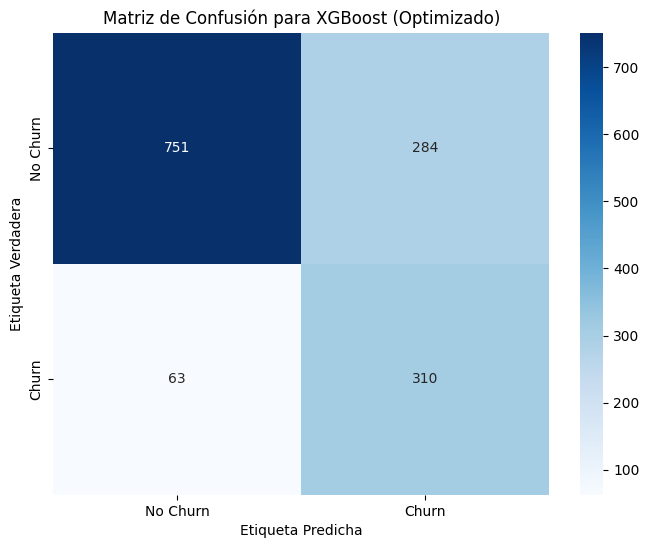


Mejor modelo y preprocesador guardados en la carpeta 'models'.

Pipeline de entrenamiento completado.


In [49]:
def run_training_pipeline(data_path: str):
    """Orquesta el pipeline completo de entrenamiento y evaluación."""

    df = load_raw_data(data_path)
    if df is None:
        return

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    X_train, y_train, preprocessor = preprocess_and_split(df_train, 'Churn')
    print("Datos de entrenamiento preprocesados y listos.")

    scoring_metric, initial_params_grid, balancing_techniques = detect_class_imbalance(y_train)

    best_overall_score = -1
    best_overall_model = None
    best_overall_technique = ''

    for tech_name, sampler in balancing_techniques.items():
        print(f"\n--- Probando la técnica: {tech_name} ---")

        steps = [('preprocessor', preprocessor)]
        if sampler:
            steps.append(('sampler', sampler))

        steps.append(('model', ModelFactory.create_model_base('xgboost')))
        model_pipeline = Pipeline(steps=steps)

        grid_search = GridSearchCV(
            estimator=model_pipeline,
            param_grid=initial_params_grid,
            cv=5,
            scoring=scoring_metric,
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)

        print(f"\nMejor {scoring_metric} para {tech_name}: {grid_search.best_score_:.4f}")
        print(f"Mejores parámetros: {grid_search.best_params_}")

        if grid_search.best_score_ > best_overall_score:
            best_overall_score = grid_search.best_score_
            best_overall_model = grid_search.best_estimator_
            best_overall_technique = tech_name

    print("\n=======================================================")
    print(f"Mejor modelo global encontrado con la técnica: {best_overall_technique}")
    print(f"Mejor {scoring_metric} global: {best_overall_score:.4f}")
    print("=======================================================")

    models_dir = 'models'
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    joblib.dump(best_overall_model, os.path.join(models_dir, 'best_overall_model.pkl'))

    X_test, y_test, _ = preprocess_and_split(df_test, 'Churn')
    y_pred = best_overall_model.predict(X_test)
    evaluate_model(y_test, y_pred, 'XGBoost (Optimizado)')

    print("\nMejor modelo y preprocesador guardados en la carpeta 'models'.")
    print("\nPipeline de entrenamiento completado.")

if __name__ == "__main__":
    DATA_PATH = '/content/drive/MyDrive/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv'
    run_training_pipeline(DATA_PATH)